# State-based dFC for voxelwise analysis

Voxelwise state-based dFC analysis is supported naturally by reshaping data to 2D `(unit, time)` and feeding it into
the same algorithms used for ROI-level analyses.

- *Units* are voxels (or surface vertices).
- *Time* is the number of volumes / TRs.

For example, with a NIfTI and brain mask, we can simply transform it into a 2D array:

In [ ]:
import numpy as np
from nilearn import datasets, maskers, plotting, image
from comet import connectivity, utils

# This will take 1-2 minutes to download, you can change verbose=1 to see the progress
save_dir = "."
haxby = datasets.fetch_haxby(data_dir=save_dir, subjects=1, verbose=0)

# Get fMRI and mask paths
fmri_path = haxby.func[0]
mask_path = haxby.mask_vt # The dataset includes multiple masks, such as a ventral-temporal mask

# Extract voxelwise time series array
masker = maskers.NiftiMasker(mask_img=mask_path, standardize=True, detrend=True, dtype='float32')
time_series = masker.fit_transform(fmri_path)
print("Time series shape:", time_series.shape)

Time series shape: (1452, 577)


We can then estimate the coactivation patterns:

CAP: 100%|██████████| 1/1 [00:04<00:00,  4.70s/it]


state_tc shape: (1, 1452)
states shape:   (577, 577, 5)


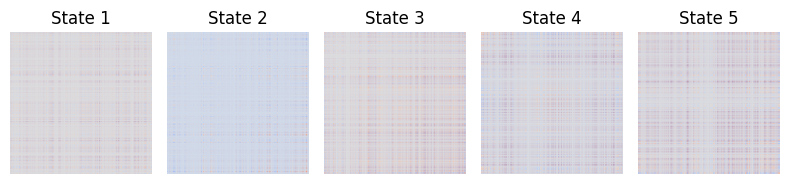

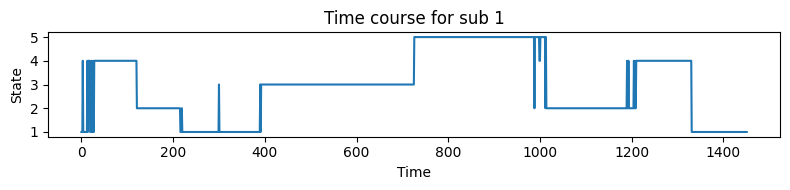

In [30]:
cap = connectivity.CoactivationPatterns(time_series=time_series, n_states=5)
state_tc, states = cap.estimate()

print("state_tc shape:", state_tc.shape)
print("states shape:  ", states.shape)

fig1, ax1 = utils.state_plots(states=states, figsize=(8,2))
fig2, ax2 = utils.state_plots(state_tc=state_tc, figsize=(8,2))

The states are (voxels x voxels) connectivity matrices created as outer products of group centroids. To obtain a voxelwise activation pattern per state for visualisation, we extract the top eigenvector of each state matrix (positive orientation). This recovers the dominant spatial pattern up to a scale/sign:


In [26]:
def top_eigenvector(A):
    # Compute leading eigenpair
    vals, vecs = np.linalg.eigh(A)
    v = vecs[:, -1]
    
    # Fix sign for stability: make the largest-magnitude element positive
    if np.abs(v).max() > 0 and np.sign(v[np.argmax(np.abs(v))]) < 0:
        v = -v
    return v.astype(np.float32)

state_vectors = np.stack([top_eigenvector(states[:, :, s]) for s in range(states.shape[2])], axis=0)  # (n_states, P)
print("Recovered state vectors (n_states, P):", state_vectors.shape)

Recovered state vectors (n_states, P): (5, 577)


We can invert the vectors back to 3D images to plot the coactivation pattern:


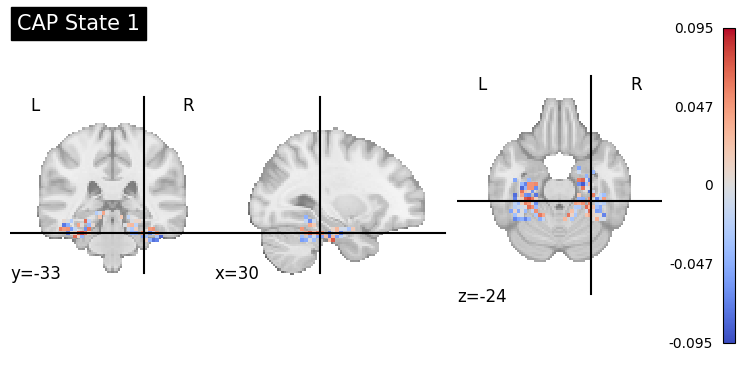

In [25]:
img = masker.inverse_transform(state_vectors)  # shape: (x, y, z, n_states)
plotting.plot_stat_map(image.index_img(img, 1), display_mode="ortho", title=f"CAP State 1", cmap="coolwarm");